In [1]:
import pandas as pd
import numpy as np
import re
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print(f"TensorFlow Version: {tf.__version__}")
sns.set_style("whitegrid")

TensorFlow Version: 2.20.0


In [2]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

print("NLTK modules are ready.")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

NLTK modules are ready.


[nltk_data] Downloading package wordnet to C:\Users\akkum/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\akkum/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
def preprocess_text(text):
    """
    A single function to clean a raw text string.
    """
    text = text.lower()
    
    text = re.sub(r'<[^>]+>', ' ', text)
    
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    
    tokens = word_tokenize(text)
    clean_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in clean_tokens]
    
    return ' '.join(lemmatized_tokens)

In [5]:
file_path = "../data/IMDB Dataset.csv"
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: Dataset file not found at {file_path}")

Dataset loaded successfully.


In [6]:
if 'df' in locals():
    print("Starting text preprocessing... (This may take a few minutes)")
    df['processed_review'] = df['review'].apply(preprocess_text)
    print("Text preprocessing complete.")
    
    print("\n--- PROCESSING EXAMPLE ---")
    print(f"Original: {df['review'].iloc[5]}")
    print(f"Processed: {df['processed_review'].iloc[5]}")

Starting text preprocessing... (This may take a few minutes)
Text preprocessing complete.

--- PROCESSING EXAMPLE ---
Original: Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it's not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother's slow awakening to what's happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they'd all be "up" for this movie.
Processed: probably alltime favorite movie story selflessness sacrifice dedication noble cause preachy boring never get old despite seen time last year paul lukas performance brings tear eye bette davis one truly sy

In [7]:
if 'df' in locals():
    X = df['processed_review']
    
    y = df['sentiment']
    
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)

if 'X' in locals():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    print(f"Data split complete:")
    print(f"X_train: {X_train.shape} | X_test: {X_test.shape}")
    print(f"y_train: {y_train.shape} | y_test: {y_test.shape}")

Data split complete:
X_train: (40000,) | X_test: (10000,)
y_train: (40000,) | y_test: (10000,)


In [8]:
vocab_size = 10000
embedding_dim = 64
max_length = 200
trunc_type = 'post' 
padding_type = 'post' 
oov_tok = "<OOV>"   

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train) 

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(train_sequences, 
                             maxlen=max_length, 
                             padding=padding_type, 
                             truncating=trunc_type)

padded_test = pad_sequences(test_sequences, 
                            maxlen=max_length, 
                            padding=padding_type, 
                            truncating=trunc_type)

print("\nKeras tokenization and padding complete.")
print(f"Padded training data shape: {padded_train.shape}")
print(f"Padded testing data shape: {padded_test.shape}")


Keras tokenization and padding complete.
Padded training data shape: (40000, 200)
Padded testing data shape: (10000, 200)


In [9]:
model_dir = "../models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

tokenizer_json = tokenizer.to_json()
with open(os.path.join(model_dir, 'tokenizer.json'), 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
print("Tokenizer saved to ../models/tokenizer.json")

Tokenizer saved to ../models/tokenizer.json


In [10]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=max_length))

model.add(SpatialDropout1D(0.2))

model.add(LSTM(units=64))

model.add(Dropout(0.5))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

C:\Users\akkum\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
print("Starting model training...")

num_epochs = 10
batch_size = 64

save_path = os.path.join(model_dir, "sentiment_model_lstm.h5")

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    verbose=1, 
    mode='min'
)

model_checkpoint = ModelCheckpoint(
    filepath=save_path, 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1, 
    mode='min'
)

history = model.fit(
    padded_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(padded_test, y_test),
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

print("Model training complete.")

Starting model training...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9160 - loss: 0.2488
Epoch 1: val_loss improved from None to 0.42091, saving model to ../models\sentiment_model_lstm.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.9145 - loss: 0.2531 - val_accuracy: 0.8544 - val_loss: 0.4209
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9236 - loss: 0.2351
Epoch 2: val_loss improved from 0.42091 to 0.40558, saving model to ../models\sentiment_model_lstm.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 103ms/step - accuracy: 0.9155 - loss: 0.2539 - val_accuracy: 0.8454 - val_loss: 0.4056
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9136 - loss: 0.2527
Epoch 3: val_loss improved from 0.40558 to 0.40080, saving model to ../models\sentiment_model_lstm.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 121ms/step - accuracy: 0.9223 - loss: 0.2346 - val_accuracy: 0.8584 - val_loss: 0.4008
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9375 - loss: 0.2022
Epoch 4: val_loss did not improve from 0.40080
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 114ms/step - accuracy: 0.9373 - loss: 0.2030 - val_accuracy: 0.8600 - val_loss: 0.4432
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9463 - loss: 0.1808
Epoch 5: val_loss did not improve from 0.40080
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 107ms/step - accuracy: 0.9431 - loss: 0.1868 - val_accuracy: 0.8629 - val_loss: 0.4268
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9461 - loss: 0.1816
Epoch 6: val_loss did not improve from 0.40080
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.9409 - loss: 0.1901 - val_accuracy: 0.8662 - val_loss: 0.4288
Epoch 6: early stopping
Model training complete.


In [20]:
loss, accuracy = model.evaluate(padded_test, y_test, verbose=0)
print(f"\n--- LSTM Model Performance ---")
print(f"Test Loss:     {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f} ({(accuracy*100):.2f}%)")


--- LSTM Model Performance ---
Test Loss:     0.4288
Test Accuracy: 0.8662 (86.62%)


In [21]:
y_pred_prob = model.predict(padded_test)
y_pred_classes = (y_pred_prob > 0.5).astype(int)

print("\n--- LSTM Classification Report ---")
print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Positive']))

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step

--- LSTM Classification Report ---
              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87      5000
    Positive       0.87      0.85      0.86      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



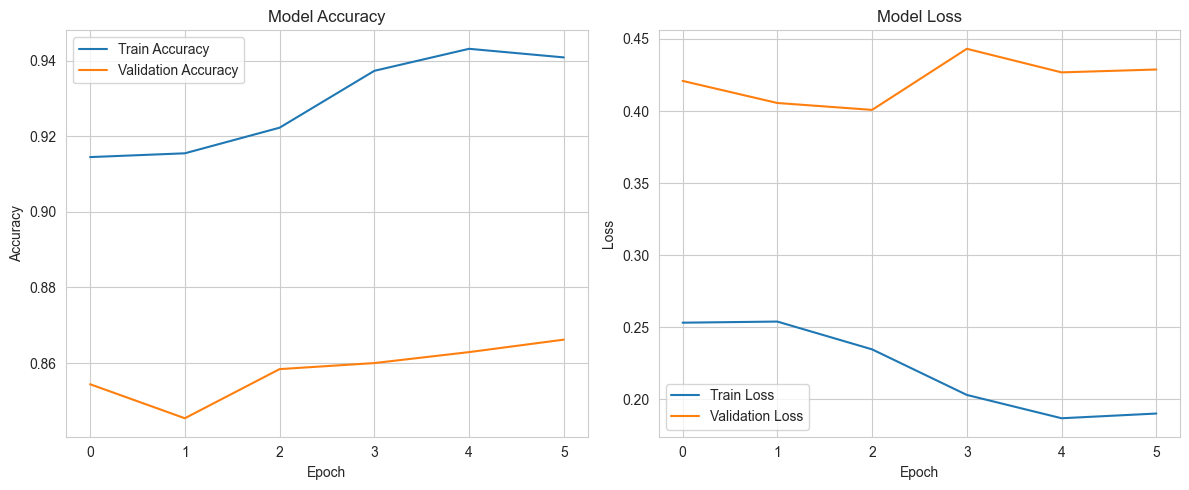

In [22]:

def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)